**Ritajit Majumdar**<br>
Enabling Technologies Researcher @ IBM Quantum<br>
majumdar.ritajit@ibm.com

## SPAM calibration via measurement twirling

State preparation and measurement (SPAM) error implies the scenario where the outcome of the state is $q \in \{0,1\}$, but it is incorrectly recorded as $q \oplus 1$ with probability $p$. The value of $p$ differs from qubit to qubit, and varies over time as well.<br>

In this notebook we shall calculate the SPAM fidelity of each qubit on a device by twirling the measurement, and then finding the expectation value of weight-1 $Z$ observable on that qubit. In other words,

<ol>
    <li>Twirl each qubit $k$ times. In this method</li>
    <ol>
        <li>a $X$ gate is applied randomly prior to the measurement.</li>
        <li>the measurement outcome is recorded.</li>
        <li>if a $X$ gate was applied, then the measurement outcome is inverted to account for it.</li>
    </ol>
    <li>$\langle Z \rangle = (1-p) - p = 1-2p$, where $p$ is the probability of SPAM error.</li>
    <li>The ideal value of $\langle Z \rangle$ should be +1 in the absence of SPAM error, and in general $-1 \leq \langle Z \rangle \leq 1$.</li>
    <li>The probability $p$ can be calculated from the obtained expectation value to obtain the SPAM fidelity of the qubit.</li>
</ol>

## Qiskit Pattern

### Step 1: Map problem to quantum hardware native format

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()  # Credentials may be needed
backend = service.get_backend('ibm_kyiv')  # Choose your desired backend

In [13]:
num_qubits = backend.num_qubits

The calibration circuit is simply a circuit where each qubit is initialized in $|0\rangle$ and is measured. The ideal outcome of each qubit is, therefore, $0$ and hence the expectation value of $\langle Z \rangle$ is `+1` for each qubit.

In [14]:
from qiskit import QuantumCircuit

calibration_circuit = QuantumCircuit(num_qubits)
calibration_circuit.measure_all()

In [15]:
calibration_circuit.draw('mpl', fold=-1)

We define $\langle Z \rangle$ observable on each qubit. Note that we require the expectation value of each of these observables separately. Therefore, we create an array containing each of these observables.

In [16]:
from qiskit.quantum_info import SparsePauliOp

observable = [SparsePauliOp('I'*i + 'Z' + 'I'*(num_qubits-i-1)) for i in range(num_qubits)]

### Step 2: Optimize circuit and observable

In order to execute the logical circuit on actual hardware we need to express it in terms of the hardware's native gates (i.e. Instruction Set Architecture, ISA), as well as assign physical qubits for execution. This action is carried out through the process of circuit transpilation.

The calibration circuit is already hardware-native, and the placement is trivial since it encompasses the entire backend. However, we still need to define the mapping of the virtual qubits from the circuit to the physical qubits. Therefore, we just call `layout` from the `preset_pass_manager`. Note that we could still use the entire `preset_pass_manager`, but using only `layout` will speed up the process.

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)

In [18]:
isa_calibration_circuit = pm.layout.run(calibration_circuit)

In [19]:
isa_calibration_circuit.draw('mpl',fold=-1)

Since the observables are already mapped to the qubits, we need not apply the circuit layout to the observables in this example.

### Step 3: Execute using Qiskit Primitives

We shall use the `EstimatorV2` primitive to run the circuit. We turn off all other error mitigation techniques by setting `resilience_level` to $0$.

In [20]:
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()

options.twirling.enable_gates = False # gate twirling is disabled
options.dynamical_decoupling.enable = False # dynamical decoupling is disabled
options.resilience_level = 0 # error mitigation is disabled

Now we turn on measurement twirling and the number of twirls is set to `32` which is the default value.

In [21]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=backend, options=options)
pub = (isa_calibration_circuit, observable)

# apply measurement twirling
estimator.options.twirling.enable_measure = True
estimator.options.twirling.num_randomizations = 32 # this is the default value
job = estimator.run([pub])

In [22]:
print(f"JOB ID: {job.job_id()}")

JOB ID: csk7zen1k2e0008nwk3g


### Step 4: Postprocess

Here we obtain the result and store the expectation value of each qubit separately. Note again that this expectation value provides us with the SPAM fidelity of each qubit.

In [23]:
result = job.result()[0]

In [24]:
Z_expectation = {idx: result.data.evs[idx] for idx in range(num_qubits)}

Note that the probability of error, $p$, can be calculated as $p = (1-\langle Z \rangle)/2$. So, we obtain the SPAM fidelity, $1-p$, as $(1+\langle Z \rangle)/2$.

In [27]:
spam_fidelity = {idx: (1+Z_expectation[idx])/2 for idx in range(num_qubits)}

In [28]:
spam_fidelity

{0: 0.989501953125,
 1: 0.99609375,
 2: 0.994384765625,
 3: 0.904541015625,
 4: 0.993896484375,
 5: 0.895751953125,
 6: 0.987060546875,
 7: 0.993896484375,
 8: 0.996826171875,
 9: 0.974609375,
 10: 0.984375,
 11: 0.998779296875,
 12: 0.97998046875,
 13: 0.996826171875,
 14: 0.989501953125,
 15: 0.994384765625,
 16: 0.993408203125,
 17: 0.978271484375,
 18: 0.99072265625,
 19: 0.97607421875,
 20: 0.96484375,
 21: 0.989501953125,
 22: 0.972900390625,
 23: 0.998291015625,
 24: 0.995361328125,
 25: 0.99658203125,
 26: 0.998291015625,
 27: 0.982666015625,
 28: 0.99169921875,
 29: 0.9892578125,
 30: 0.977294921875,
 31: 0.98974609375,
 32: 0.9921875,
 33: 0.9873046875,
 34: 0.9951171875,
 35: 0.994873046875,
 36: 0.995361328125,
 37: 0.960205078125,
 38: 0.96240234375,
 39: 0.976806640625,
 40: 0.957275390625,
 41: 0.984375,
 42: 0.9912109375,
 43: 0.9765625,
 44: 0.93017578125,
 45: 0.995849609375,
 46: 0.84765625,
 47: 0.97607421875,
 48: 0.995849609375,
 49: 0.91455078125,
 50: 0.99609375

We can visualize the SPAM fidelities on the hardware coupling map. For this, we group the fidelities $f$ in ranges [$0.99 < f < 1$, $0.98 < f < 0.99$, $0.98 < f < 0.97$, $0.97 < f < 0.96$, $0.96 < f < 0.95$, $0.95 < f < 0.9$, $f < 0.9$]. Conforming to the coloring convention of qiskit, the lighter the color, the higher is the probability of error.

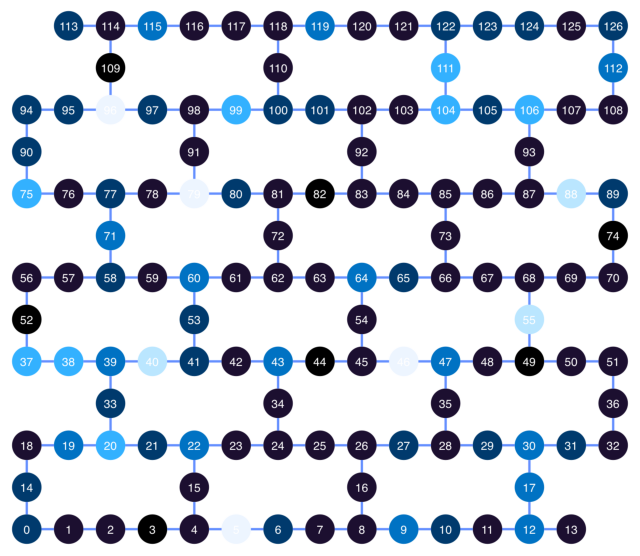

In [75]:
from qiskit.visualization import plot_gate_map

qubit_color = []
for i in range(backend.num_qubits):
    if spam_fidelity[i] > 0.99:
        qubit_color.append("#1c0f30")
    elif spam_fidelity[i] > 0.98:
        qubit_color.append('#003a6d')
    elif spam_fidelity[i] > 0.97:
        qubit_color.append('#0072c3')
    elif spam_fidelity[i] > 0.96:
        qubit_color.append('#33b1ff')
    elif spam_fidelity[i] > 0.95:
        qubit_color.append('#bae6ff')
    elif spam_fidelity[i] > 0.9:
        qubit_color.append('e5f6ff')
    else:
        qubit_color.append("#edf5ff")
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=20, figsize=(8,8))

### Practice

#### Challenge 1

Determine the outlier qubits in terms of SPAM error. For example, in the above run, qubit 46, having a SPAM fidelity of $\sim 0.84$, is clearly an outlier since most of the other qubits have a SPAM fidelity $\sim 0.97-0.99$. Use some statistical technique (e.g. <a href='https://en.wikipedia.org/wiki/Standard_score'>Z-score</a>) to determine the outlier qubits.

#### Challenge 2

In this notebook, we used twirling followed by calculation of weight-1 Z observable to calculate SPAM fidelity. However, SPAM fidelity can also be determined by separately executing circuits where the qubits are initialized in $|0\rangle$ and $|1\rangle$. From these, we obtain the separate probabilities $p(q|q \oplus 1)$, $q \in \{0,1\}$, and the SPAM fidelity can be determined by averaging these two values.<br>

Next, we use this method to determine $p(0|1)$ and $p(1|0)$ for a particular qubit.

In [76]:
qubit_idx = 20

In [77]:
zero_calibration = QuantumCircuit(1)
zero_calibration.measure_all()

one_calibration = QuantumCircuit(1)
one_calibration.x(0)
one_calibration.measure_all()

Let us visualize the two calibration circuits

In [78]:
zero_calibration.draw()

░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0

In [79]:
one_calibration.draw()

┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0

Now we transpile the circuits by setting the qubit_idx as the layout.

In [80]:
pm_calibration = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=[qubit_idx])
isa_calibration = pm_calibration.run([zero_calibration, one_calibration])

Since we require the probability distribution here, we shall invoke the Sampler primitive.

In [81]:
from qiskit_ibm_runtime import SamplerV2

sampler = SamplerV2(backend=backend)
sampler.options.twirling.enable_measure = False # disable measurement twirling

calibration_job = sampler.run(isa_calibration)

In [82]:
print(f"CALIBRATION JOB ID: {calibration_job.job_id()}")

CALIBRATION JOB ID: cskxngevnxy0008d6q9g


In [85]:
zero_calibration_result = calibration_job.result()[0].data.meas.get_counts()
one_calibration_result = calibration_job.result()[1].data.meas.get_counts()

In [89]:
p10 = zero_calibration_result['1']/sum(zero_calibration_result.values())
print(f'p(1|0) = {p10}')

p(1|0) = 0.007080078125


In [91]:
p01 = one_calibration_result['0']/sum(zero_calibration_result.values())
print(f'p(0|1) = {p01}')

p(0|1) = 0.0751953125


Now, we can obtain the `spam_fidelity` by obtaining the average of $p(0|1)$ and $p(1|0)$.

In [94]:
spam_fidelity_calibration = 1-(p10 + p01)/2
print(f'SPAM fidelity obtained without twirling is {spam_fidelity_calibration}')

SPAM fidelity obtained without twirling is 0.9588623046875


We can obtain the same SPAM fidelity without twirling from backend calibration data as well. This will provide the same data as determined during the last backend calibration.

In [95]:
p01_backend = backend.properties().qubit_property(qubit_idx, 'prob_meas0_prep1')[0]
p10_backend = backend.properties().qubit_property(qubit_idx, 'prob_meas1_prep0')[0]

print(f'p(0|1) of qubit {qubit_idx} as obtained from backend properties is {p01_backend}')
print(f'p(1|0) of qubit {qubit_idx} as obtained from backend properties is {p10_backend}')

p(0|1) of qubit 20 as obtained from backend properties is 0.025000000000000022
p(1|0) of qubit 20 as obtained from backend properties is 0.0204


In [96]:
spam_fidelity_backend = 1-(p01_backend+p10_backend)/2
print(f'SPAM fidelity of qubit {qubit_idx} as obtained from calibration data is {spam_fidelity_backend}')

SPAM fidelity of qubit 20 as obtained from calibration data is 0.9773


Note that the same data can also be obtained by simply calling `backend.properties().readout_error()`

In [97]:
print(f'SPAM fidelity of qubit {qubit_idx} as obtained from calibration data is {1-backend.properties().readout_error(qubit_idx)}')

SPAM fidelity of qubit 20 as obtained from calibration data is 0.9773000000000001


We note that the three SPAM fidelities are slightly different. A few observations are

<ol>
    <li>$p(0|1) > p(1|0)$. This is primarily because the probability of obtaining $0$ when the actual outcome is $1$ is affected both by measurement error and damping error.</li>
    <li>Twirling removes the asymmetry in the values $p(0|1)$ and $p(1|0)$, and creates a symmetric channel.</li>
    <li>Quality of the qubit changes over time. The values of SPAM fidelity obtained from the calibration data may be slightly outdated. Hence we obtain a slightly different result when we run the calibration circuits ourselved.</li>
</ol>

<BarContainer object of 3 artists>

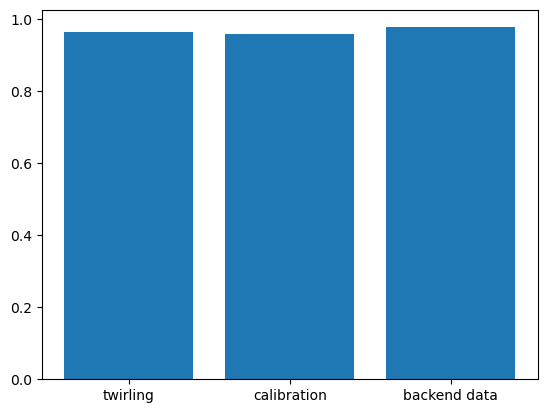

In [100]:
import matplotlib.pyplot as plt

methods = ['twirling', 'calibration', 'backend data']
values = [spam_fidelity[qubit_idx], spam_fidelity_calibration, spam_fidelity_backend]

plt.bar(methods, values)

**Question**: Repeat the two types of calibrations, and obtain the backend calibration data and plot the `bar graph` for each qubit.<br>

**Hint**: You don't need a separate calibration circuit for each qubit when determining $p(0|1)$ and $p(1|0)$. You can run calibration circuit for all the qubits simultaneously, and obtain the data for each qubit by marginalizing over the others.

#### Challenge 3

We consider a low-depth mirrored circuit so that the expectation value is +1 for any $Z$ type observable. We make it a low-depth circuit to ensure that the SPAM errors are most dominant ones when obtaining the noisy outcome.

In [35]:
from qiskit.circuit import Parameter

def create_low_depth_mirrored_circuit(num_qubits: int) -> QuantumCircuit:
    assert num_qubits%2 == 0, "Even number of qubits is expected"
    
    qc = QuantumCircuit(num_qubits)
    theta = Parameter("θ")
    
    qc.rx(theta, range(num_qubits))

    for i in range(0,num_qubits,2):
        qc.cx(i,i+1)

    for i in range(1,num_qubits-1,2):
        qc.cx(i,i+1)

    qc_inv = qc.inverse()
    qc.barrier()
    qc.compose(qc_inv, inplace=True)

    return qc

We fix the observable to be the average of all weight-1 $Z$ type observable.

In [36]:
num_qubits = 6

In [101]:
circuit = create_low_depth_mirrored_circuit(num_qubits)

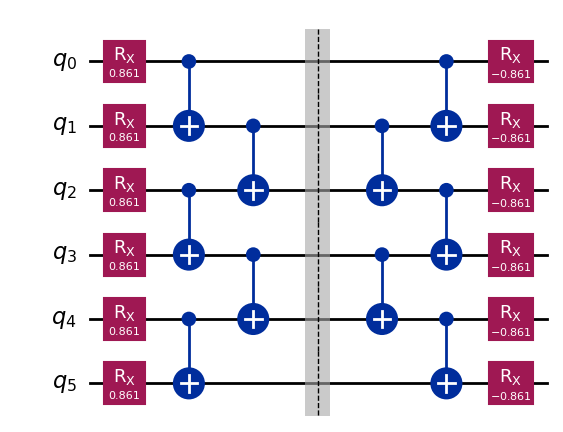

In [38]:
from numpy import pi
from numpy.random import default_rng

rng = default_rng(seed=0)
parameter_values = rng.uniform(-pi, pi, size=circuit.num_parameters)

circuit.assign_parameters(parameter_values, inplace=True)
circuit.draw('mpl', fold=-1)

In [39]:
from qiskit.quantum_info import SparsePauliOp

paulis = ['I'*i + 'Z' + 'I'*(num_qubits-i-1) for i in range(num_qubits)]
coeffs = 1/len(paulis)

observable = SparsePauliOp(paulis, coeffs)
print(observable)

SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ'],
              coeffs=[0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j, 0.16666667+0.j,
 0.16666667+0.j, 0.16666667+0.j])


##### Transpilation by defining own layout

Let us first convert the circuit into basis gates without fixing any particular layout

In [40]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
seed_transpilation = 42

pm = generate_preset_pass_manager(optimization_level=3, basis_gates=backend.configuration().basis_gates, seed_transpiler=seed_transpilation)

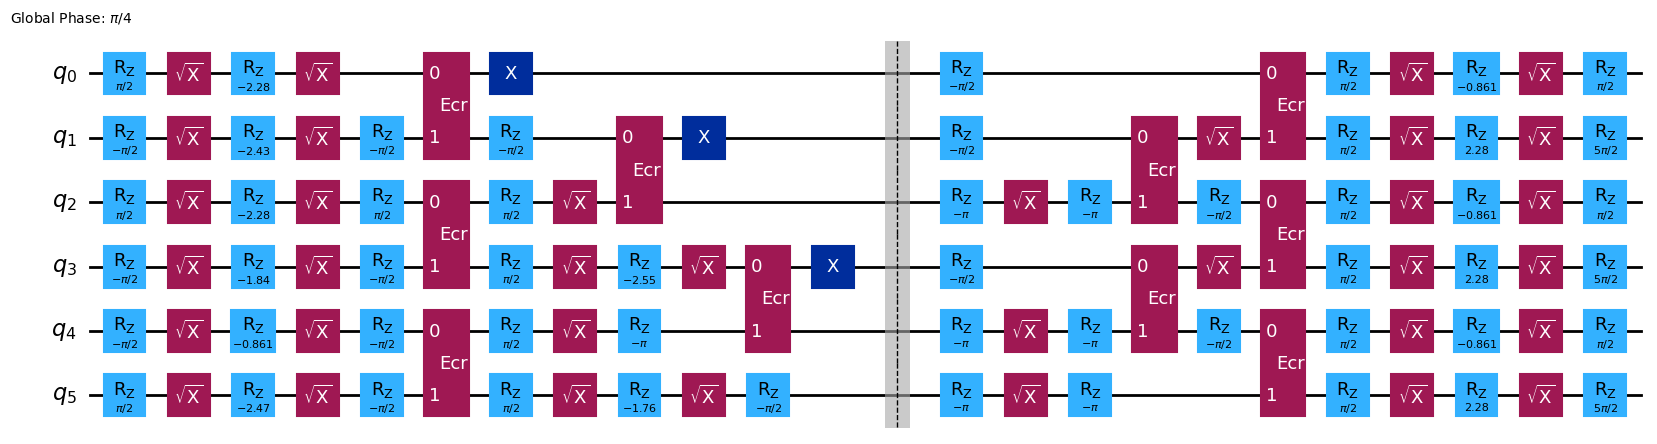

In [41]:
basis_circuit = pm.run(circuit)
basis_circuit.draw('mpl', fold=-1)

Now, let us consider two layouts: $l_1 = [46,47,48,49,50,51]$ and $l_2 = [103,104,105,106,107,108]$. We can visualize the two layouts using `plot_gate_map` function from `qiskit_visualization`.

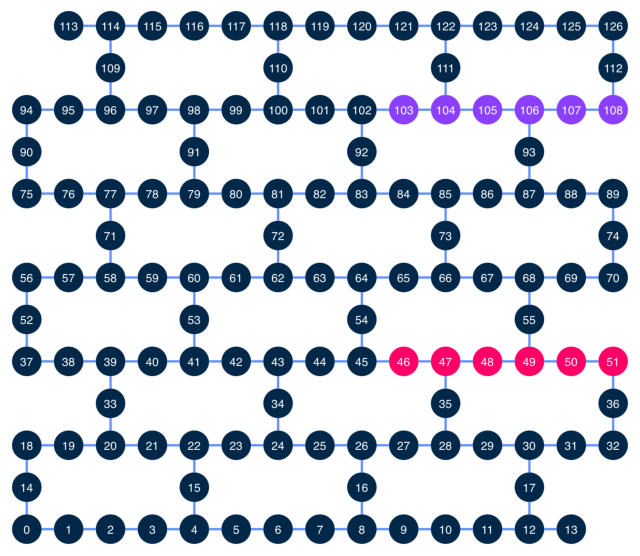

In [83]:
l1 = [46,47,48,49,50,51]
l2 = [103,104,105,106,107,108]

qubit_color = []
for i in range(backend.num_qubits):
    if i in l1:
        qubit_color.append("#ff0066")
    elif i in l2:
        qubit_color.append('#8a3ffc')
    else:
        qubit_color.append("#012749")
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=20, figsize=(8,8))

We first note the SPAM fidelity of both the layouts.

In [67]:
from numpy import mean

print(f'Average SPAM fidelity of layout l1 is {mean([spam_fidelity[idx] for idx in l1])}')
print(f'Average SPAM fidelity of layout l2 is {mean([spam_fidelity[idx] for idx in l2])}')

Average SPAM fidelity of layout l1 is 0.9544677734375
Average SPAM fidelity of layout l2 is 0.9844970703125


The SPAM fidelity of l1 is worse than that of l2. Therefore, we can expect that the expectation value obtained when the circuit is transpiled on the layout l1 should be worse than that on l2.

In [44]:
pm_l1 = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=l1)
pm_l2 = generate_preset_pass_manager(optimization_level=0, backend=backend, initial_layout=l2)

In [52]:
isa_circuit_l1 = pm_l1.run(basis_circuit)
isa_circuit_l2 = pm_l2.run(basis_circuit)

We can verify that the layouts of these two transpiled circuits match the provided layouts.

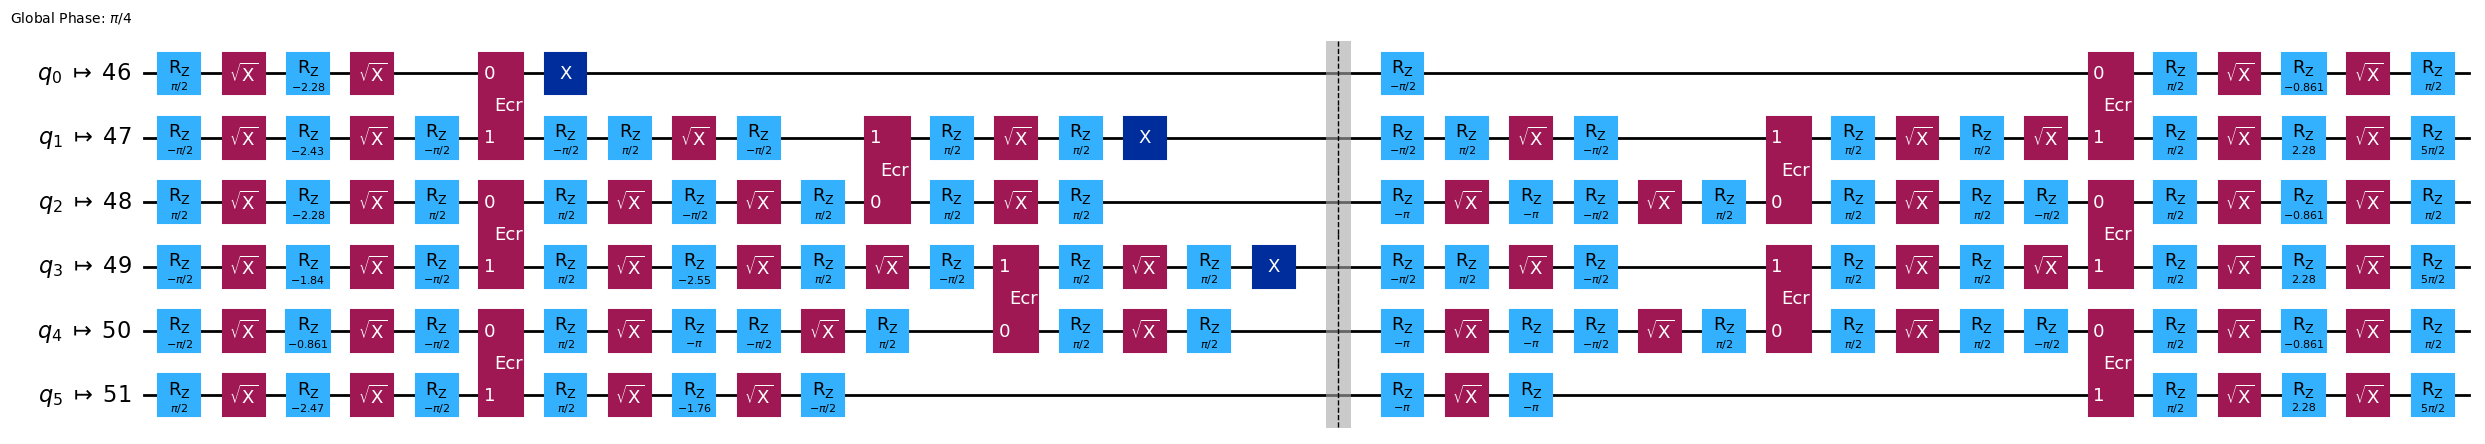

In [53]:
isa_circuit_l1.draw('mpl', fold=-1, idle_wires=False)

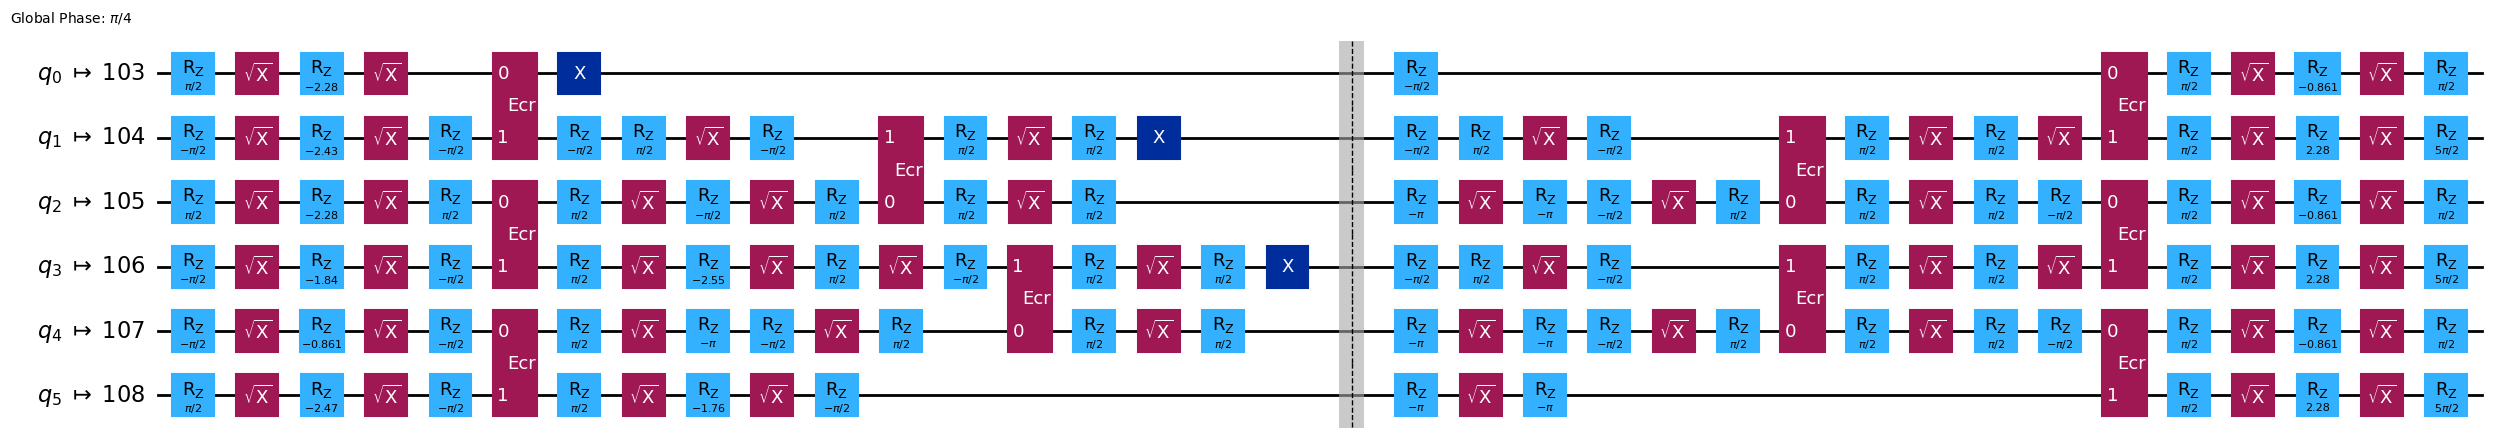

In [54]:
isa_circuit_l2.draw('mpl', fold=-1, idle_wires=False)

Now we apply the corresponding layouts to the observable

In [55]:
isa_observable_l1 = observable.apply_layout(isa_circuit_l1.layout)
isa_observable_l2 = observable.apply_layout(isa_circuit_l2.layout)

Now we execute both the circuits on an estimator primitive. We shall not use any mitigation or suppression for this experiment.

In [56]:
options = EstimatorOptions()

options.twirling.enable_gates = False # gate twirling is disabled
options.twirling.enable_measure = False # measurement twirling is disabled
options.dynamical_decoupling.enable = False # dynamical decoupling is disabled
options.resilience_level = 0 # mitigation is disabled

In [57]:
estimator = EstimatorV2(backend=backend, options=options)

In [58]:
job = estimator.run([(isa_circuit_l1, isa_observable_l1),(isa_circuit_l2, isa_observable_l2)])

In [59]:
print(f"JOB ID: {job.job_id()}")

JOB ID: csk84hap1vzg008a224g


In [68]:
expval_l1 = job.result()[0].data.evs
expval_l2 = job.result()[1].data.evs

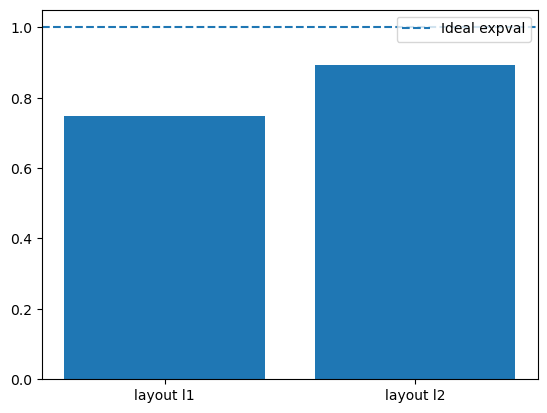

In [70]:
import matplotlib.pyplot as plt

methods = ['layout l1', 'layout l2']
mean_values = [expval_l1, expval_l2]

plt.bar(methods, mean_values)
plt.axhline(y = 1, linestyle = '--', label='Ideal expval')
plt.legend()

plt.show()

**Inference**: Note that for this study no suppression or mitigation technique was used. However, the selection of layout leads to a non-trivial difference in the obtained expectation value.

**Question**: Select 10 different layouts, and calculate the mean SPAM fidelity of each. 

<ol>
    <li>Run the same circuit on each layout, and report the expectation value.</li>
    <li>Draw a plot on the variation in the expectation value with the variation in the average SPAM fidelity of each layout</li>
    <li>Determine the nature of the curve of the degradation in expectation value vs average SPAM fidelity - is it linear, polynomial, or exponential?</li>
</ol>

#### Challenge 4

<ol>
    <li>Repeat the exercise of Challenge 3 for circuits with different number of qubits. Does the nature of the degradation curve remains same with increase in qubit counts?</li>
    <li>Vary the depth of the circuit (for example, increase the number of CNOT layers in the example circuit), and repeat the same experiment. Does the nature of the degradation curve remains the same with increase in depth?</li>
</ol>